<a href="https://colab.research.google.com/github/Hebaehab765/AI4GoodLab/blob/main/M2_Friday_Project_2_E3_SS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Our Task
Categorize each image into one of **four** disease categories or mark it as a **healthy** leaf

So, we need to train a CNN model that correctly classify images of leaves. For example, we expect something like this:

[image of a healthy leaf] --> CNN --> [1, 0, 0, 0, 0]

[image of a leaf with disease#1] --> CNN --> [0, 1, 0, 0, 0]

...

...

[image of a leaf with disease#4] --> CNN --> [0, 0, 0, 0, 1]

## Loading the Dataset
Before loading the dataset and running those steps, please ensure the notebook is running on a GPU instance.

In [ ]:
from typing import Callable, Any, Optional
import os
import zipfile
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from PIL import Image
import pandas as pd
import numpy as np
from torchvision.transforms import v2
from torchvision.models import shufflenet_v2_x0_5, ShuffleNet_V2_X0_5_Weights
import tqdm
from sklearn import model_selection

class CassavaDataset(Dataset):
    def __init__(self, path_to_dataset, root: str  = "./data", transform: Optional[Callable[[Any], Any]] = None, train: bool = True, seed=1234):
        super().__init__()
        self.root = os.path.join(root, 'cassava-leaf-disease-classification')
        self.transform = transform

        if not os.path.exists(os.path.join(self.root, 'train.csv')):
            print("Extracting the dataset. This can take a few minutes. While the dataset is being extracted, start thinking on how to use the data.")

            with zipfile.ZipFile(path_to_dataset, 'r') as z:
                z.extractall(self.root)
            print("Successfully extracted the data !")

        dataset = pd.read_csv(os.path.join(self.root, 'train.csv'), dtype={'image_id': str, 'label': np.uint8})
        label_values = dataset.label.values
        if label_values is None:
            raise ValueError("No labels found in the dataset")

        trainset, validset = model_selection.train_test_split(dataset, test_size=0.1, random_state=42, stratify=label_values)
        if train:
            self.dataset = trainset
        else:
            self.dataset = validset


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self,idx):  #overriding getitem. It defines how we iterate over trainset. This methods enables us to write syntaxes like trainset[0], or for sample in trainset:
        data = self.dataset.iloc[idx]
        filename = os.path.join(self.root, "train_images", data["image_id"])
        img = Image.open(filename)

        if self.transform:
            img = self.transform(img)

        label = data["label"]

        return {
            'image': img,
            'target': torch.tensor(label,dtype=torch.float)
        }

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainset = CassavaDataset('/content/drive/My Drive/Friday_Project_2/cassava-leaf-disease-classification.zip', train=True)
validset = CassavaDataset('/content/drive/My Drive/Friday_Project_2/cassava-leaf-disease-classification.zip', train=False)

print(f"Trainset size: {len(trainset)}, Validset size: {len(validset)}")

#trainset is an instance of the CassavaDataset class
#because of how we wrote the getitem method, trainset[0] would be a dictionary with keys ['image', 'target'], that looks like:
#print(trainset[0]) #{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x600 at 0x79823283F010>, 'target': tensor(1.)}

Extracting the dataset. This can take a few minutes. While the dataset is being extracted, start thinking on how to use the data.
Successfully extracted the data !
Trainset size: 19257, Validset size: 2140


## Baseline Model

Now we evaluate a baseline model written by someone else.

1. We have a pre-trained model saved in our drive already! So, someone trained a CNN model and saved it for us, named as 'baseline.pt'.

2. Now we just load that model and evaluate that on our test data

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:

from torchmetrics.classification import MulticlassConfusionMatrix, Accuracy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BaselineModel(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.model = shufflenet_v2_x0_5(weights=ShuffleNet_V2_X0_5_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes) #whatever #in_features this shufflenet's fc (fullyConnected) layer has, keep it as it is, just change the #out_features to be equal to num_classes

    def forward(self, x):
        return self.model(x)

    @staticmethod
    def load(filename: str):
        checkpoint = torch.load(filename, map_location=torch.device(device))
        model = BaselineModel(checkpoint["num_classes"])
        model.load_state_dict(checkpoint["params"])
        return model

def evaluate(model: nn.Module, dataloader: DataLoader, metrics, device, debug: bool = False):
    for metric in metrics:
      metric.to(device)
      metric.reset()

    model.eval()
    with torch.no_grad():
        for data in tqdm.tqdm(dataloader):
            inputs, labels = data['image'].to(device), data['target'].to(device).long()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            for metric in metrics:
              metric.update(outputs, labels)

            if debug:
                break

    return metrics

In [ ]:
BATCH_SIZE = 128
NUM_WORKERS = 2
NUM_CLASSES = 5


transforms = ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1.transforms()
validset = CassavaDataset('/content/drive/MyDrive/Friday_Project_2/cassava-leaf-disease-classification.zip', train=False, transform=transforms)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model = BaselineModel.load('/content/drive/MyDrive/Friday_Project_2/baseline.pt').to(device)

print("Evaluating baseline model...")

acc, confusion_matrix = evaluate(model, validloader, [Accuracy(task="multiclass", num_classes=NUM_CLASSES), MulticlassConfusionMatrix(num_classes=NUM_CLASSES)], device)

print(f"Valid Accuracy: {acc.compute():.2%}")

confusion_matrix.plot()

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth
100%|██████████| 5.28M/5.28M [00:00<00:00, 40.7MB/s]


Evaluating baseline model...


  0%|          | 0/17 [00:00<?, ?it/s]

# Your turn to Code !

Now, we have to train a model that has HIGHER accuracy than the baseline!

Before that, let's take a quick look to our dataset. It might help us choosing a model!

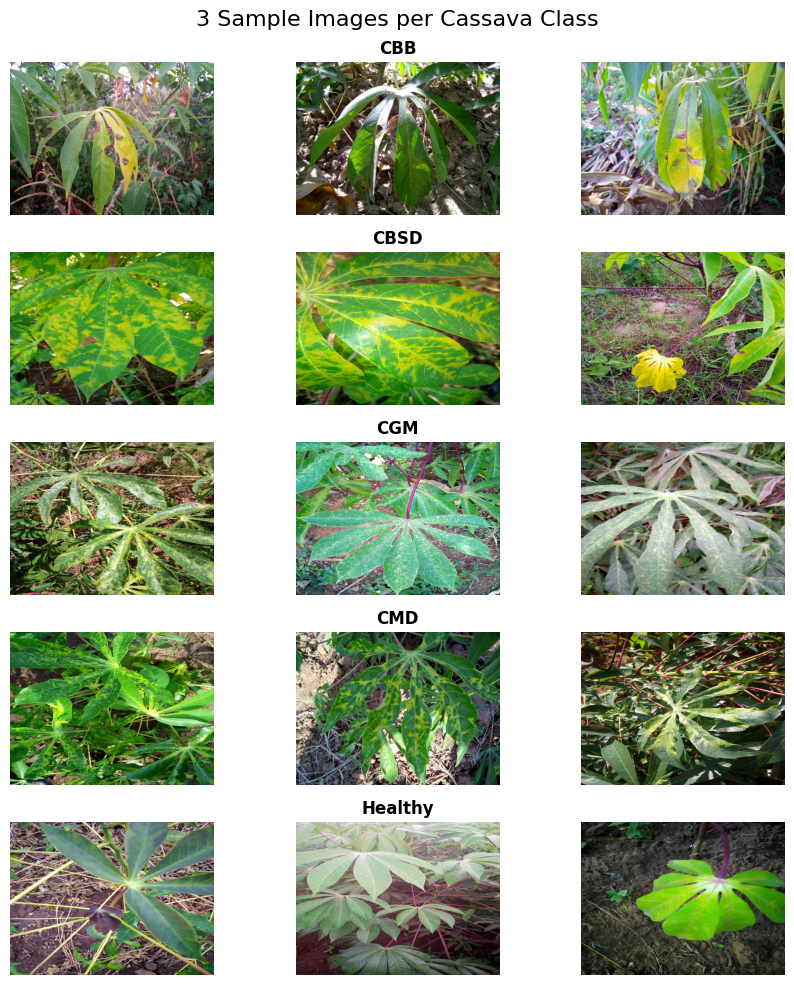

In [ ]:
# Write your code here...
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import DataLoader
from collections import defaultdict
import torchvision.transforms as T

#1. Loaders for training and test data
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

#2. Let's see some images!

# Mapping from class index to name
class_names = {
    0: "CBB",     # Cassava Bacterial Blight
    1: "CBSD",    # Cassava Brown Streak Disease
    2: "CGM",     # Cassava Green Mottle
    3: "CMD",     # Cassava Mosaic Disease
    4: "Healthy"
}

# Dictionary to hold collected samples
samples_per_class = defaultdict(list)

# Collect 3 samples per class
for sample in trainset:   #remember, this sample would be a dictionary with keys ['image', 'label']
    label = sample['target']
    label = label.item()    #read the value from the tensor
    if len(samples_per_class[label]) < 3:
        samples_per_class[label].append(sample['image'])
    # Break early if all classes are filled
    if all(len(v) == 3 for v in samples_per_class.values()):
        break

# Plot
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(9, 10))
for class_idx, row_axes in zip(range(5), axes):
    for i, ax in enumerate(row_axes):
        image = samples_per_class[class_idx][i]
        image_tensor = T.ToTensor()(image)  #convert to tensor so we can use .permute to reshape image
        ax.imshow(image_tensor.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        ax.axis('off')
        if i == 1:
            ax.set_title(class_names[class_idx], fontsize=12, weight='bold')

plt.suptitle("3 Sample Images per Cassava Class", fontsize=16)
plt.tight_layout()
plt.show()



Counter({3.0: 11842, 4.0: 2319, 2.0: 2148, 1.0: 1970, 0.0: 978})


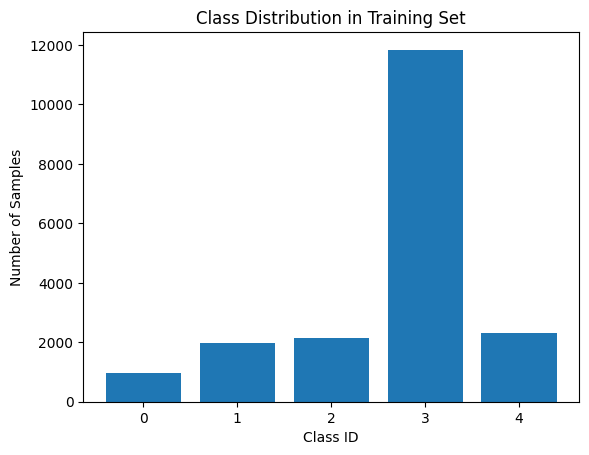

In [ ]:
#now, let's check if training data distribution is good enough!

from collections import Counter

# Extract all targets
targets = [sample['target'].item() for sample in trainset]
class_counts = Counter(targets)
print(class_counts)  #class_counts is an object of the Counter class, which is a special type of dictionary.

# Plot
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class ID")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Set")
plt.show()


##IMPORTANT
remember this class_counts variable... we'll use it later!

#Problems Found

1. Some images show only plant leaves (GOOD!). But, some have other things-- stem, root, background, soil, grass, and even other plants! How would a ML model know 'where to look'? What if it just thinks soils are important, while clearly it's not! More formally, the model might learn spurious correlations (e.g., predicting class 3 just because it often appears with soil background).

2. Such an imbalanced class distribution in our training data! This might cause the model to favor the more frequent class more than the less frequent ones. This can also result into MISLEADING ACCURACY. Example: here around 61% data belongs to class 3, so even if my model learns nothing and just predict everything as *class 3*, it gets 62% accuracy! Learn nothing and still get 62% accuracy--> this isn't good!



#Let's Solve them one-by-one!

Proble #1: We'd go for segmentation to address this issue

In [ ]:
import cv2

# This function does the segmentation. We'd do a color-based segmentation to isolate the yellow-green portions
def segment_leaf(pil_image):
    #YOUR TASK 1
    #convert the pil_image to a numpy array, cause we can't work directly on raw image. Store it in a variable named 'img'



    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  #we go to hue, saturation, brightness value space to identify green-yellow regions

    lower_green = np.array([25, 40, 40]) #hue 25 to 95 is the range for green, s=0 is greyscale, so start from some initial value like 40, same for brightness, we need some amount of brightness, so lower threshold cant be 0
    upper_green = np.array([95, 255, 255]) #255,255 cause we want to take until the fully green (no grey tone) and brightest green,
    mask = cv2.inRange(hsv, lower_green, upper_green)
    result = cv2.bitwise_and(img, img, mask=mask)

    #YOUR TASK 2
    #'result' is a BGR image. convert it to an RGB image (hint: search for opencv convert BGR to RGB). Store the RGB image in a variable named result_rgb



    return result_rgb

# Set output folders
train_out = "/content/drive/MyDrive/Friday_Project_2/segmented_images/train"
test_out = "/content/drive/MyDrive/Friday_Project_2/segmented_images/test"
os.makedirs(train_out, exist_ok=True)
os.makedirs(test_out, exist_ok=True)

# Function to save segmented dataset
def segment_and_save(dataset, split_name, output_folder):
    for i in tqdm.tqdm(range(len(dataset))):
        sample = dataset[i]
        img_pil = sample['image']  # already a PIL image if transform is None, else tensor

        # Convert tensor to PIL if needed
        if isinstance(img_pil, torch.Tensor):
            img_np = img_pil.permute(1, 2, 0).numpy()
            img_pil = Image.fromarray((img_np * 255).astype(np.uint8))

        segmented = segment_leaf(img_pil)

        # Save image
        img_name = dataset.dataset.iloc[i]["image_id"]
        out_path = os.path.join(output_folder, img_name)
        Image.fromarray(segmented).save(out_path)

# Run for train and test
segment_and_save(trainset, "train", train_out)
segment_and_save(validset, "test", test_out)


  0%|          | 0/19257 [00:00<?, ?it/s]

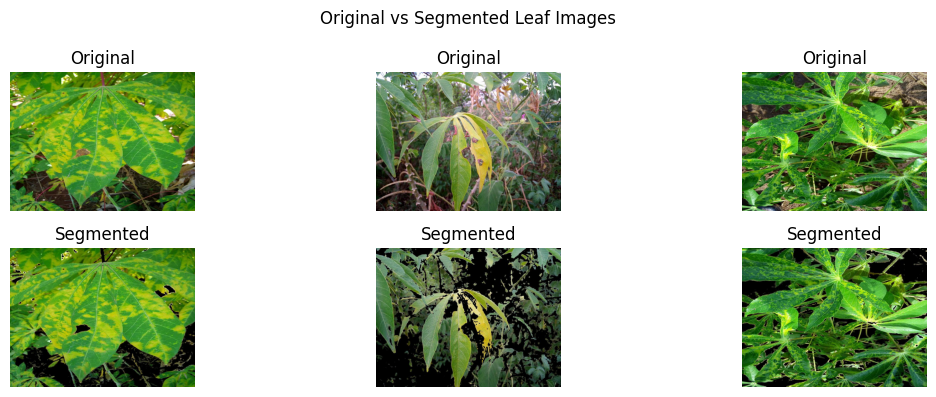

In [ ]:
#let's see how our segmentation worked!

def show_segmented_samples(dataset, folder, num_samples=3):
    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        row = dataset.dataset.iloc[i]
        original_path = os.path.join(dataset.root, "train_images", row["image_id"])
        segmented_path = os.path.join(folder, row["image_id"])

        original = Image.open(original_path)
        segmented = Image.open(segmented_path)

        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original)
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(segmented)
        plt.title("Segmented")
        plt.axis('off')

    plt.suptitle("Original vs Segmented Leaf Images")
    plt.tight_layout()
    plt.show()

# Show 3 samples from trainset
train_out = "/content/drive/MyDrive/Friday_Project_2/segmented_images/train"
show_segmented_samples(trainset, train_out, num_samples=3)


#Problem #2: we use class-weighted loss to make sure that our model doesn't favor the frequent class more.

In [ ]:
#Remember class_counts ?
#Now, we use that dictionary-thingy to calculate weights for each class
#This is how class_counts looks like: {3.0: 11842, 4.0: 2319, 2.0: 2148, 1.0: 1970, 0.0: 978}

#let's sort class_counts
class_counts= dict(sorted(class_counts.items())) #now it'd look like {0.0:978, 1.0:...}

#We'd use inverse frequency weight: total_samples / (num_classes * class_count)

#YOUR TASK 3

#a) count total number of samples and store it in some variable
total_samples = len(trainset)
print(total_samples)

#b) define num_classes
num_classes = 5


#c) complete the loop below so we get this list populated
list_of_weights_for_each_class= []

for key, value in class_counts.items(): #this is how we usually iterate through a dictionary
  #calculate weight for this class: total_samples / (num_classes * class_count) and append it to the list we defined above
  weight = total_samples / (num_classes * value)
  list_of_weights_for_each_class.append(weight)

#We're done! Later, when we train our model, we'll use this list to calculate a class-weighted loss function.
print(list_of_weights_for_each_class)


#Note: pytorch won't accept a list, so just convert it to a tensor
weight_tensor = torch.tensor(list_of_weights_for_each_class, dtype=torch.float).to(device)

19257
[3.938036809815951, 1.95502538071066, 1.7930167597765363, 0.3252322242864381, 1.6608020698576973]


## Training a Model

In [ ]:
class SegmentedCassavaDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row['image_id'])
        label = int(row['label'])

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'target': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
import zipfile
import os
from torchvision.models import ResNet18_Weights

zip_path = '/content/drive/MyDrive/Friday_Project_2/segmented_images.zip'
extract_to = '/content/segmented_images'

# Only extract if not already extracted
if not os.path.exists(extract_to):
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction done!")
else:
    print("Zip file already extracted.")

train_img_dir = os.path.join(extract_to, 'segmented_images/train')
test_img_dir  = os.path.join(extract_to, 'segmented_images/test')

train_csv = "./data/cassava-leaf-disease-classification/train.csv"


#class to load dataset
class SegmentedCassavaDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_dir, row['image_id'])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = int(row['label'])
        return {'image': image, 'target': torch.tensor(label, dtype=torch.long)}



Extracting zip file...
Extraction done!


In [ ]:
def train_model(model, trainloader, optimizer, num_epochs=5):
    criterion = nn.CrossEntropyLoss(weight= weight_tensor)
    train_acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
    val_acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        total_loss = 0
        train_acc.reset()

        for batch in trainloader:
            images = batch['image'].to(device)
            labels = batch['target'].to(device).long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_acc.update(outputs, labels)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss:.4f} - Train Acc: {train_acc.compute():.2%}")


In [ ]:
# Paths to folders
train_img_dir = "/content/segmented_images/segmented_images/train"
test_img_dir = "/content/segmented_images/segmented_images/test"

# Read full CSV
csv_path = "./data/cassava-leaf-disease-classification/train.csv"
df = pd.read_csv(csv_path)

# Get image filenames from disk
train_images = set(os.listdir(train_img_dir))
test_images = set(os.listdir(test_img_dir))

# Filter DataFrame based on where images are stored
train_df = df[df['image_id'].isin(train_images)].reset_index(drop=True)
val_df   = df[df['image_id'].isin(test_images)].reset_index(drop=True)

# Save splits
train_df.to_csv('/content/train_split.csv', index=False)
val_df.to_csv('/content/val_split.csv', index=False)

print(f"Train images found: {len(train_df)}")
print(f"Test images found: {len(val_df)}")


#train loader
transform = ResNet18_Weights.DEFAULT.transforms()

train_dataset = SegmentedCassavaDataset('/content/train_split.csv', train_img_dir, transform=transform)
test_dataset  = SegmentedCassavaDataset('/content/val_split.csv', test_img_dir, transform=transform)
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
testloader  = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


NameError: name 'pd' is not defined

In [ ]:
import torchvision.models as models

resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18.fc = nn.Linear(resnet18.fc.in_features, NUM_CLASSES)
resnet18 = resnet18.to(device)
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-4)
train_model(resnet18, trainloader, optimizer, num_epochs=5)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]
 20%|██        | 1/5 [03:02<12:08, 182.12s/it]

Epoch 1/5 - Train Loss: 144.4058 - Train Acc: 66.62%


 40%|████      | 2/5 [05:59<08:58, 179.55s/it]

Epoch 2/5 - Train Loss: 73.6820 - Train Acc: 84.50%


 60%|██████    | 3/5 [08:54<05:54, 177.12s/it]

Epoch 3/5 - Train Loss: 23.8852 - Train Acc: 94.41%


 80%|████████  | 4/5 [11:51<02:57, 177.28s/it]

Epoch 4/5 - Train Loss: 7.0654 - Train Acc: 98.48%


100%|██████████| 5/5 [14:50<00:00, 178.07s/it]

Epoch 5/5 - Train Loss: 2.2288 - Train Acc: 99.70%


Evaluating resnet18 model...


100%|██████████| 17/17 [00:19<00:00,  1.17s/it]

ResNet18 Accuracy: 80.28%


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

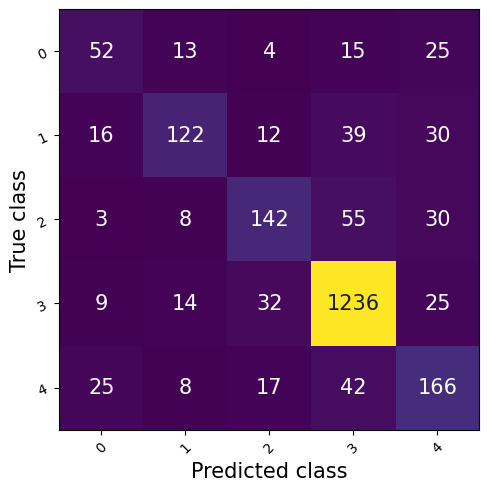

In [ ]:
#we've an evaluate method written above, just call that one for this resnet model
print("Evaluating resnet18 model...")

acc, confusion_matrix = evaluate(resnet18, testloader, [Accuracy(task="multiclass", num_classes=NUM_CLASSES), MulticlassConfusionMatrix(num_classes=NUM_CLASSES)], device)
print(f"ResNet18 Accuracy: {acc.compute():.2%}")
confusion_matrix.plot()

Your Tasks
1. Can you find any other problems with the dataset that might be causing low classification performance? If yes, can you try resolving the issues?
(A Hint: data augmentation may help with class imbalance)

2. Can you try some other pre-trained models from torchvision.models to see if we get better performance?


In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

NUM_CLASSES = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


resnext50 = models.resnext50_32x4d(progress=True)
resnext50.fc = nn.Linear(resnext50.fc.in_features, NUM_CLASSES)
resnext50 = resnext50.to(device)
optimizer = torch.optim.Adam(resnext50.parameters(), lr=1e-4)
train_model(resnext50, trainloader, optimizer, num_epochs=5)


NameError: name 'train_model' is not defined

In [ ]:
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T


# Create the augmentation pipeline, p=0.5 is flip with a 50% probability.
augmentations = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=(0, 360)),  # Full 360-degree range for flexibility
])

#create a path to the folder
image_folder_path = "/content/segmented_images/segmented_images/train"
train_dataset = datasets.ImageFolder(root=image_folder_path, transform=augmentations)


for batch in trainloader:
  images = batch['image'].to(device)
  labels = batch['target'].to(device).long()
  for label in labels:
    if label != 3:
      augmentations(image) #Apply the augmentations only to images that class_name is not the 3rd class


FileNotFoundError: [Errno 2] No such file or directory: '/content/segmented_images/segmented_images/train'